# 1. Import required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from util import get_pipeline, run_prediction
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from scipy.misc import toimage
from sklearn.decomposition import PCA

Using TensorFlow backend.


# 2. Load housing data

In [2]:
df = pd.read_csv('Dataset\HousesInfo.txt', delimiter=" ", header=0)
df.head()

,bed,bath,sqft,zip,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


We will drop `zip` column from the dataset to make the analysis simple. With `zip` we would need to one-hot-encoding this data column. In the actual model implementation, this column is definitely important, however the purpose of this analysis is to see how images can improve the prediction accuracy, therefore we can safely discard `zip` without much influence on the final result.

In [3]:
data = df[['bed', 'bath', 'sqft', 'price']].copy()

The next step is to run prediction to see how well we can predict housing price with the current dataset  
For this we split the existing dataset of **535** houses to **80% for training** and **20% for testing**

# 3. Predict housing price with XGBRegressor

`XGBRegressor` is a decision-tree-based ensemble Machine Learning regression algorithm that uses a gradient boosting framework.
unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks. However, when it comes to small-to-medium structured/tabular data, decision tree based algorithms are considered best-in-class.

R2: 0.07312235853011728
MAE: 234951.6339077103


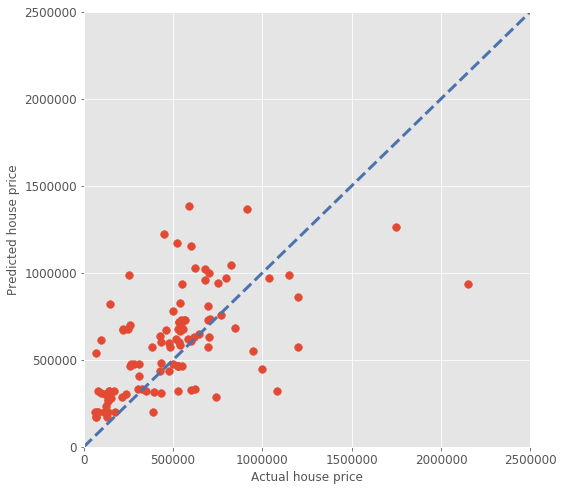

In [4]:
RANDOM_STATE = 4
X = data.drop(['price'], axis=1)
y = data[['price']].values.reshape(-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
run_prediction(X_train, X_test, y_train, y_test)

An **R2** value of **0.07** indicates that this model has some predictive power, it is better than blindly guessing the average price, albeit not very impressive.  
**MAE** of **234,951** means that for each house, the average difference between predicted price and the actual price is **$234,951**.  
Now we will see how we can leverage housing images to make a better model

# 4. Predict housing price with XGBRegressor and image features

## 4.1 Auto image features extraction

![House images](images\dataset.png)

  
For each house in this dataset, we have 4 images capturing bedroom, bathroom, kitchen and frontal view. All images were scraped from *realtor.com* in 2016. In order to utilize this extra source of information, we will first need to convert images to features, so that it can be consumed by `XGBRegressor` along with other existing features.

There are many different ways to achieve this. The approach that I use in this analysis is to do **transfer learning** (illustration below). We start with a **pre-trained** deep convoluted neural network (DCNN) model ([VGG16](https://neurohive.io/en/popular-networks/vgg16/)). VGG16 is a very deep convolutional neural network consisting of many layers of small convolution and pooling filters, followed by a two fully connected layers and a softmax output. We will remove the network's softmax and dense layers, and consume the output from its previous one. 

The intuition behind this approach is that if a model trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. We can then take advantage of these learned feature maps without having to start from scratch training a large model on a large dataset. It is a great solution for this analysis, since we don't have much data to train the model. For actual project implementation, I would suggest re-train the model from scratch with only house images. That way the model can pick up most important features specifically for houses and maximize its performance.

<img src="images\transfer.png" width="800">

### 4.2 Dimension reduction with Principal Component Analysis (PCA)

Since VGG16 is a deep network, it's next-to-last layer contains thousands of features that the network was able to extract from the input image. We simply cannot digest everything and risk overfitting the model. [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) is a technique that can help us reducing the dimension of the dataset, only retain the most important components that describe the largest possible data variance. For each input image, we will only retain **4 most important components**.

Illustration of the entire ML pipeline

<img src="images\workflow.png" width="800">

Below is the combined code for extracting image features and run PCA to reduce dimension

In [8]:
PCA_COMPONENTS = 4
IMG_DIM = 256
IMG_SHAPE = (IMG_DIM, IMG_DIM, 3)
pretrained_model = VGG16(include_top=False, input_shape=IMG_SHAPE, weights='imagenet')
img_df = data.copy()

for img_type in ['bathroom', 'frontal', 'kitchen', 'bedroom']:
    all_features = []
    for i in range(1,536):
        img = image.load_img(f'Dataset\\{i}_{img_type}.jpg', target_size=(IMG_DIM,IMG_DIM))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)

        features = pretrained_model.predict(img)
        all_features.append(features.flatten())

    all_features = np.array(all_features)
    all_features.shape

    # run PCA on all_features to reduce data dimension, keep only the 4 best principal components
    pca = PCA(n_components=PCA_COMPONENTS)
    transformed_PCA_features = pca.fit_transform(all_features)

    # merge into img_df
    columns = [img_type + '_PCA_' + str(i) for i in range(1,PCA_COMPONENTS + 1)]
    img_df = img_df.join(pd.DataFrame(transformed_PCA_features, columns=columns))

Let's have a look at our current dataframe after being augmented with image features

In [9]:
img_df.head()

,bed,bath,sqft,price,bathroom_PCA_1,bathroom_PCA_2,bathroom_PCA_3,bathroom_PCA_4,frontal_PCA_1,frontal_PCA_2,frontal_PCA_3,frontal_PCA_4,kitchen_PCA_1,kitchen_PCA_2,kitchen_PCA_3,kitchen_PCA_4,bedroom_PCA_1,bedroom_PCA_2,bedroom_PCA_3,bedroom_PCA_4
0,4,4.0,4053,869500,-123.985809,112.988503,513.249939,-10.683521,144.292297,-98.406685,143.322311,140.646637,570.833618,-310.872620,-131.264145,407.364441,247.217072,-170.809586,-198.912003,-25.895588
1,4,3.0,3343,865200,-9.219336,-146.844177,312.605499,-20.217607,-408.661957,148.358170,-23.650925,201.932114,199.580322,59.006641,340.210358,66.582390,-37.743237,166.841415,-232.295013,296.814789
2,3,4.0,3923,889000,402.826538,162.548019,-204.590927,-158.089600,46.158863,-188.568130,-100.434814,305.320282,279.762726,183.252502,399.387878,25.358326,166.174973,-295.138763,-66.873169,46.500446
3,5,5.0,4022,910000,164.837036,23.223177,164.071640,191.025452,191.047470,-217.287064,28.541739,120.537819,390.484863,-341.260864,-66.230164,59.543221,-375.963379,-231.563049,-81.768845,-293.531342
4,3,4.0,4116,971226,137.177444,47.761944,-329.874786,447.260406,-401.659973,219.090347,-76.021400,165.897095,408.081818,-190.868256,128.541473,-270.532318,76.951942,-312.354218,-46.921101,-207.709305


For each house, we have 16 new features (4 principal components for each image on bathroom, frontal, kitchen, bedroom). Note that this dataset only contain 1 image per category, if we have multiple images per category, we just simply need to calculate its mean value.

We will again do a 80/20 train/test split and run prediction

R2: 0.29257578223413083
MAE: 219713.19626168226


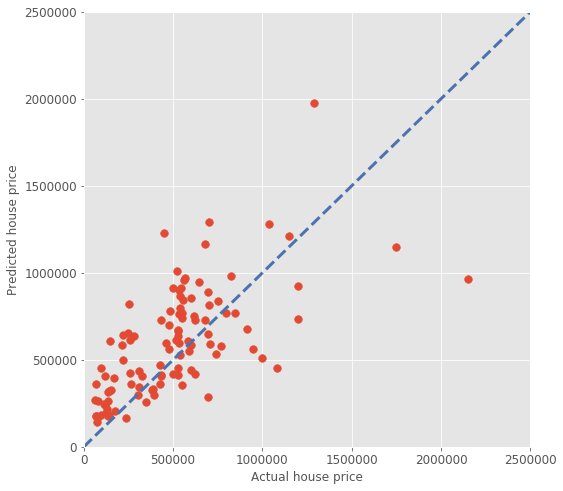

In [10]:
X_img = img_df.drop(['price'], axis=1)
y_img = img_df[['price']].values.reshape(-1)
X_img_train, X_img_test, y_img_train, y_img_test = train_test_split(X_img, y_img, test_size=0.2, random_state=RANDOM_STATE)
run_prediction(X_img_train, X_img_test, y_img_train, y_img_test)

Result is much better this time with R2 increases to 0.292 from 0.073 (**300% increment**) and MAE reduces to 219,713 from 234,951 (**5.3% reduction**). Both performance metrics confirm that utilizing house images can improve the prediction capability of the existing model.

# 5. Further and beyond

This analysis serves as a proof-of-concept that we can utilize house images in improving price prediction accuracy. In summary, the idea is to first automatically extract image features using transfer learning on a pre-trained DCNN model and run PCA to reduce data dimension, then augment the original dataset with new features and run that through a regressor to predict housing price. The techniques that we might use in the actual project, however, are drastically different from those in this toy-example. In this section, we discuss the differences and extra steps that we could consider to maximize model performance.

### 5.1 Transfer learning vs. training from scratch

Transfer learning is a great technique to be used in this analysis, given extreme contrains in time, resource and data. In practice, transfer learning works best where we use a pre-trained model to solve a problem that is similar to the problem the network was originally trained to solve. For example, we can re-use a network that was built to identify dogs to classify dogs and cats. To the best of my knowledge, there is no publicly available DCNN model that were built specifically on a house image dataset. Therefore important features that the network learned from its training could be irrelevant and have little predictive power in assessing house values.

If we have lots of house images and computing power is not an issue, I would definitely re-train a DCNN model so it could pick the best features. That way we can maximize model accuracy.

### 5.2 House image classification

Before extracting features, it is crucial to know the context of each image so we can best quantify its impact to housing price. This dataset already provide us with 4 images capturing 4 important aspects of a house. In practice, we would need a classifier that can automate the process. This should be a simple task. Given enough training, DCNNs are known to have achieved human performance in many classification tasks ([reference](https://arxiv.org/pdf/1705.02498.pdf)). Furthermore, we would need to classify images into additional categories as well, like `backyard`, `pool`, `street view`. Those extra information could be helpful for the model.

<img src="images\classifier.png" width="800">

### 5.3 Model tuning

Model tuning is an important step where we improve performance of a selected model by optimizing its hyper parameters. Best set of hyper parameters for the model can be found using techniques like `grid search` or `randomize search`. Normally I would perform a `randomize search` first to narrow down the parameter space, then follow by a `grid search` to get the optimal result. We did not perform model tuning here since it is a time-consuming process. We can tune both DCNN and `XGBRegressor` models.

### 5.4 Other data sources

In order to maximizing predicting accuracy, we can also consider extra sources of information that can assist our model:
  * **Satellite images**: contextual information about the surrounding areas was shown to be a valuable information in determining housing prices ([reference](https://vision.ece.ucsb.edu/sites/default/files/publications/bency_wacv_17.pdf))
  * **Realtor commentaries**: analysing commetaries using techniques like NLP could reveal hidden information that influence the price
  * **Nearby prices**: it is well-known that a value of a house is heavily influenced by nearby prices. It is an important data source and should not be ignored. We can study this data using RNN and LSTM models.